In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mode
import math
%matplotlib inline


In [52]:
matches = pd.read_csv('matches.csv')
delivery = pd.read_csv('deliveries.csv')
match_ids = matches[matches.season >= 2016]['id'].unique()
matches1 = matches[(matches.season >= 2016) & (matches['result']=='normal')]
matches1 = matches1.drop(['player_of_match','venue','umpire1','umpire2','umpire3', 'dl_applied', 'city', 'date', 'result'], axis=1)
matches1.dropna(inplace=True)

In [53]:
def team_correction(row):
    row = row.strip()
    if row == 'Delhi Daredevils':
        return 'Delhi Capitals'
    if row == 'Rising Pune Supergiants':
        return 'Rising Pune Supergiant'
    return row

for col in ['team1', 'team2', 'winner', 'toss_winner']:
    matches1[col] = matches1[col].apply(team_correction)
    

In [54]:
team_1 = 'Sunrisers Hyderabad'
team_2 = 'Royal Challengers Bangalore'

In [55]:
delivery = delivery[delivery.match_id.apply(lambda x: True if x in match_ids else False)]
for col in ['batting_team', 'bowling_team']:
    delivery[col] = delivery[col].apply(team_correction)

delivery.fillna(0, inplace=True)
delivery['player_dismissed'] = delivery['player_dismissed'].apply(lambda x: 0 if x==0 else 1)

delivery['batsman_runs'] = delivery['batsman_runs'].apply(lambda x: x-1 if ((x==7) or (x==5)) else x)

In [56]:
def clean(row):
    if row['extra_runs']>= row['batsman_runs']:
        row['extra_runs'] -= row['batsman_runs']
        
    return row

delivery = delivery.apply(clean, axis=1)
delivery['total_runs'] = delivery['extra_runs'] + delivery['batsman_runs']
delivery['bowler'] = delivery['bowler'].apply(lambda x: 'Sandeep Sharma' if x=='S Sharma' else x)

# Winning Probability of Teams

Text(0.5, 1.0, 'RCB Total Runs Score Stats Per Count')

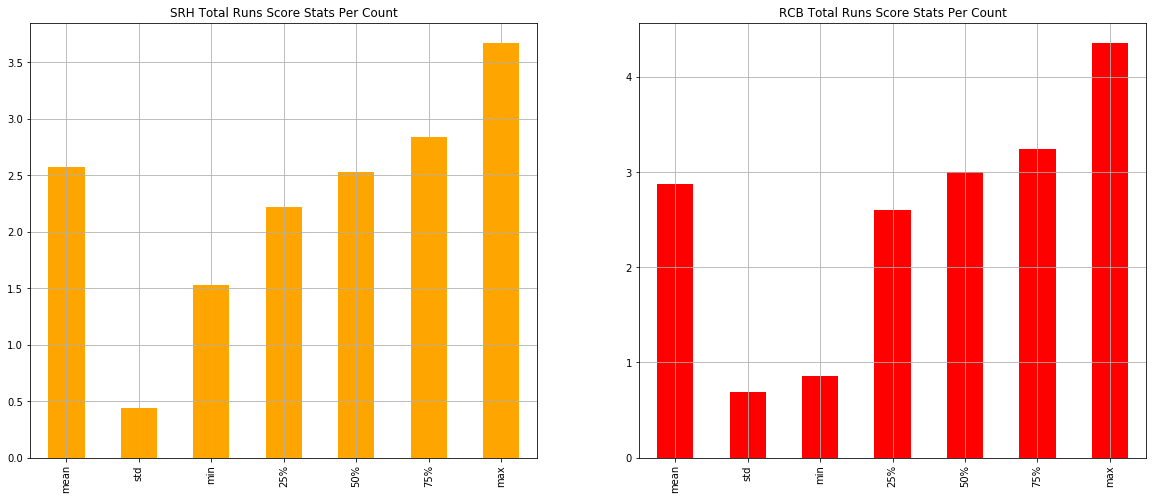

In [57]:
fig, ax = plt.subplots(1,2, figsize=(20,8))
srh_runs = delivery[delivery['batting_team']==team_1].groupby('match_id').sum()['total_runs']
rcb_runs = delivery[delivery['batting_team']==team_2].groupby('match_id').sum()['total_runs']
(srh_runs.describe()[1:]/srh_runs.describe()[0]).plot(ax=ax[0], kind='bar', grid=True, color='orange')
(rcb_runs.describe()[1:]/rcb_runs.describe()[0]).plot(ax=ax[1], kind='bar', grid=True, color='red')
ax[0].set_title("SRH Total Runs Score Stats Per Count")
ax[1].set_title("RCB Total Runs Score Stats Per Count")

Text(0.5, 1.0, 'Percentage of Winning')

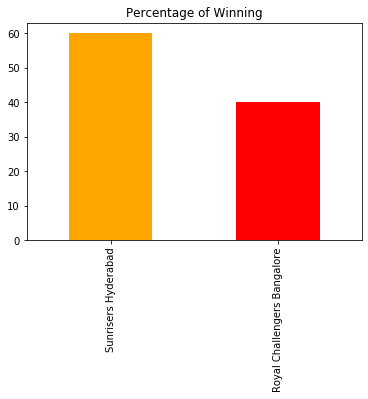

In [109]:
wins = pd.DataFrame(matches1[(matches1['team1'].isin([team_1, team_2])) & (matches1['team2'].isin([team_1, team_2])) & (matches1['season']>2016)]['winner'].value_counts())
wins['Percentage Win Chance'] = (wins['winner']/sum(wins['winner']))*100
wins['Percentage Win Chance'].plot(kind='bar', color=['orange', 'red'])
plt.title('Percentage of Winning')

# Economy Rate of Sandeep Sharma and boundaries given

In [59]:
def economy_rate(bowler):
    rates = list()
    for match_id in delivery[(delivery['bowler']==bowler)]['match_id'].unique():
        
        match = delivery[(delivery['bowler']==bowler) & (delivery['match_id']==match_id)]
        b_4s = len(match[(match['total_runs'].isin([4, 5]))])
        b_6s = len(match[(match['total_runs'].isin([6, 7]))])
        t_runs = sum(match['total_runs'])
        total_b = b_4s + b_6s
        balls = len(match)
        
        if (balls/6 > 3):
            rate = t_runs*6/balls
            rates.append([bowler, t_runs, balls, b_4s, b_6s, total_b, round(rate, 2)])
        
    return rates

In [66]:
sharma = pd.DataFrame(economy_rate('Sandeep Sharma'), columns=['Bowler', 'Runs', 'Balls', '4s', '6s', 'Total Boundaries','ER'])
sharma.describe()

,Runs,Balls,4s,6s,Total Boundaries,ER
count,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000
mean,30.511628,24.232558,2.767442,1.093023,3.860465,7.540930
std,10.459382,1.887770,1.586209,1.042295,2.018738,2.523749
min,9.000000,19.000000,1.000000,0.000000,1.000000,2.750000
25%,23.000000,24.000000,2.000000,0.000000,2.500000,5.660000
50%,31.000000,24.000000,2.000000,1.000000,4.000000,7.620000
75%,38.000000,25.000000,4.000000,2.000000,4.500000,9.375000
max,55.000000,28.000000,7.000000,4.000000,9.000000,13.750000


# Strike Rate

In [80]:
def strike_rate(batsman):
    ratios = list()
    for match_id in delivery[(delivery['batsman']==batsman)]['match_id'].unique():
        match = delivery[(delivery['batsman']==batsman) & (delivery['match_id']==match_id)]
        total_runs = sum(match['batsman_runs'])
        total_balls = len(match)
        total_4 = len(match[match['batsman_runs']==4])
        total_6 = len(match[match['batsman_runs']==6])
        
        if total_balls>10: 
            rate = total_runs*100/total_balls
            ratios.append([batsman, total_runs, total_balls, total_4, total_6, rate])
        
    return ratios

In [111]:
srh_team = ['DA Warner', 'WP Saha', 'MK Pandey', 'Rashid Khan', 'K Ahmed', 'T Natarajan', 'S Sharma', 'JO Holder', 'KS Williamson']
rcb_team = ['Washington Sundar','AB de Villiers' ,'V Kohli', 'AJ Finch', 'YS Chahal', 'CH Morris', 'S Dube', 'N Saini', 'Gurkeerat Singh']
teams = srh_team+rcb_team

In [112]:
batsman_sr = list()
for man in teams:
    batsman_sr += (strike_rate(man))

In [113]:
batsman_sr_df = pd.DataFrame(data=batsman_sr, columns=['Batsman', 'Runs', 'Balls', '4s', '6s', 'SR'])
batsman_sr_df.groupby("Batsman").mean().sort_values(by='4s')

,Runs,Balls,4s,6s,SR
Batsman,,,,,
S Dube,24.000000,16.000000,0.000000,2.000000,150.000000
YS Chahal,4.000000,12.000000,0.000000,0.000000,33.333333
Washington Sundar,37.000000,21.000000,1.000000,3.000000,176.190476
Rashid Khan,35.000000,11.000000,2.000000,4.000000,318.181818
CH Morris,35.250000,22.000000,2.500000,1.875000,155.161697
MK Pandey,33.837838,26.594595,2.648649,0.864865,118.537095
WP Saha,30.100000,23.250000,3.300000,0.450000,129.055114
Gurkeerat Singh,34.166667,25.000000,3.333333,0.833333,129.944444
AJ Finch,42.823529,30.647059,4.000000,1.823529,141.394756


Text(0.5, 1.0, 'Mean number of 4s per match')

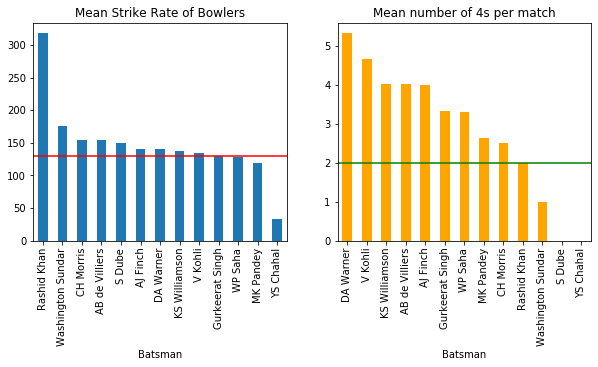

In [114]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
batsman_sr_df.groupby("Batsman").mean().sort_values(by='SR', ascending=False)['SR'].plot(kind='bar', ax=ax[0])
ax[0].axhline(y=130, color='red')
batsman_sr_df.groupby("Batsman").mean().sort_values(by='4s', ascending=False)['4s'].plot(kind='bar', ax=ax[1], color='orange')
ax[1].axhline(y=2, color='green')
ax[0].set_title('Mean Strike Rate of Bowlers')
ax[1].set_title("Mean number of 4s per match")

Considering both the condition and frontline batsmen, the range will be 5-6

# Batsman Ratio

In [115]:
def batsman_ratio(batsmen):
    ratios = list()
    for man in batsmen:
        for match_id in delivery[(delivery['batsman']==man)]['match_id'].unique():
            match = delivery[(delivery['match_id']==match_id) & (delivery['batsman']==man)]
            if len(match)>10:
                b_runs = sum(match[(match['batsman_runs'].isin([4,6]))]['batsman_runs'])
                s_runs = sum(match[(match['batsman_runs'].isin([1, 2, 3]))]['batsman_runs'])
                t_runs = sum(match['batsman_runs'])
                ratio = (b_runs-s_runs)/t_runs
                ratios.append([man, ratio])
    return ratios

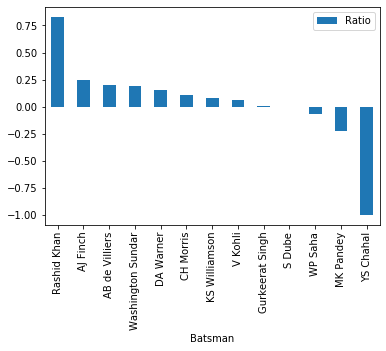

In [116]:
batsmans_performance = pd.DataFrame(data=batsman_ratio(teams), columns=['Batsman', 'Ratio'])
batsmans_performance.groupby('Batsman').mean().sort_values(by='Ratio', ascending=False).plot(kind='bar')

# Wickets Fall in Powerplay

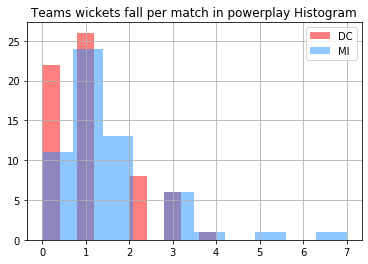

In [117]:
delivery[(delivery['batting_team']==team_1) & (delivery['over']<=6)].groupby('match_id').sum()['player_dismissed'].hist(alpha=0.5, color='red', label='DC')
delivery[(delivery['batting_team']==team_2) & (delivery['over']<=6)].groupby('match_id').sum()['player_dismissed'].hist(alpha=0.5, color='dodgerblue', label='MI')
plt.title("Teams wickets fall per match in powerplay Histogram")
plt.legend()

Both teams histogram suggests that they loose generally 1 wicket in powerplay. So, their sum wil be 2. 

# Summary

1. Using winners column and comparing team score mean values, the chances of winning were calculated.
2. Function to calculate economy rate per match of a bowler was created using total_runs column to calculate total runs, 4s, 6s, balls, and finds econ rate using formula. Median of these values was considered for S Sharma. 
3. Function to calculate strike rate using batsman_runs column to calculate total runs, 4s, 6s, scored, and balls faced by each batsman per match. Using formula, SR rate was calculated. Mean values were plotted and compared to find range. 
4. Function to calculate batsman ratio using batsman_runs column and finding runs by single, boundaries and total runs and getting ratio using formula for each batsman per match. Mean values were plotted and compared. 
5. Wickets in powerplay per match for both the teams were calculated by using player_dismissed column and histogram was plotted and frequency peaks were summed. 